In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

from tqdm import tqdm

In [2]:
SEED = 42
KERAS_VERBOSITY = 0

In [3]:
display(tf.config.list_physical_devices('CPU'))
display(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# HELPER FUNCTIONS

In [4]:
def eval_model_np(model, data_test):
    est_trues = np.zeros(len(data_test))
    est_preds = np.zeros(len(data_test))
    for i, zip_data in enumerate(data_test):
        y_preds = model.predict(zip_data[0], verbose=KERAS_VERBOSITY)
        est_trues[i] = zip_data[1][0]
        est_preds[i] = y_preds[0][0]

    return est_trues, est_preds

def eval_model_df(model, data_test):
    est_trues, est_preds = eval_model_np(model, data_test)
    
    return pd.DataFrame({'est_trues': est_trues,
                         'est_preds': est_preds})    

# DATA INGESTION

In [5]:
file_path = '../../../src/data/temp/lagged_zbp_totals_with_features.csv'
data = pd.read_csv(file_path)
data.head()

,zip,year,est,emp_nf,emp,qp1_nf,qp1,ap_nf,ap,naics_11_pct,...,n50_99_pct,n100_249_pct,n250_499_pct,n500_999_pct,n1000_pct,median_hh_income,total_population,total_retirement,total_midcareer (25-34),total_midcareer (35-44)
0,91901,2013,402,H,4141.0,H,36304.0,H,174786.0,0.000000,...,0.010230,0.005115,0.002558,0.000000,0.002558,76496.0,17034.0,2691.0,1441.0,2011.0
1,91901,2014,392,H,4808.0,H,54568.0,H,188411.0,0.000000,...,0.012438,0.007463,0.000000,0.002488,0.002488,79792.0,17123.0,2678.0,1693.0,1786.0
2,91901,2015,397,H,4436.0,H,45258.0,H,171382.0,0.002551,...,0.012755,0.010204,0.000000,0.000000,0.002551,81379.0,18184.0,3075.0,1989.0,1598.0
3,91901,2016,390,H,4255.0,H,37704.0,H,151533.0,0.000000,...,0.012594,0.005038,0.000000,0.000000,0.002519,79859.0,18507.0,3158.0,1947.0,1683.0
4,91901,2017,413,H,4515.0,H,39556.0,H,167307.0,0.000000,...,0.015385,0.010256,0.000000,0.000000,0.002564,81603.0,18586.0,3236.0,1771.0,1909.0


# DATA PROCESSING (OHE)

In [6]:
included_feats = data.columns.drop(['emp_nf', 'qp1_nf', 'ap_nf'])
data = data[included_feats]

In [7]:
preproc = ColumnTransformer([('onehots', OneHotEncoder(handle_unknown='ignore'), ['zip'])]
                             ,remainder = 'passthrough')

ohe_data = preproc.fit_transform(data)

feature_names = preproc.get_feature_names_out()
feature_names = np.char.replace(feature_names.astype('str'), 'onehots__','')
feature_names = np.char.replace(feature_names, 'remainder__','')

ohe_data = pd.DataFrame(ohe_data, columns=feature_names)
ohe_data.head()

,zip_91901,zip_91902,zip_91906,zip_91910,zip_91911,zip_91913,zip_91914,zip_91915,zip_91916,zip_91932,...,n50_99_pct,n100_249_pct,n250_499_pct,n500_999_pct,n1000_pct,median_hh_income,total_population,total_retirement,total_midcareer (25-34),total_midcareer (35-44)
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.010230,0.005115,0.002558,0.000000,0.002558,76496.0,17034.0,2691.0,1441.0,2011.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.012438,0.007463,0.000000,0.002488,0.002488,79792.0,17123.0,2678.0,1693.0,1786.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.012755,0.010204,0.000000,0.000000,0.002551,81379.0,18184.0,3075.0,1989.0,1598.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.012594,0.005038,0.000000,0.000000,0.002519,79859.0,18507.0,3158.0,1947.0,1683.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.015385,0.010256,0.000000,0.000000,0.002564,81603.0,18586.0,3236.0,1771.0,1909.0


# TRAIN TEST SPLIT

In [8]:
class CustomTimeSeriesSplit:
    def __init__(self, n_splits=None):
        self.n_splits = n_splits

    def split(self, X, y=None, groups=None):
        
        year_range = np.sort(X['year'].unique())
        min_year = year_range[0]
        
        self.n_splits = len(year_range) - 1
        
        for test_year in year_range[1:]:
            curr_range = np.arange(min_year, test_year)
            train = X[X['year'].apply(lambda year: year in curr_range)].index.to_numpy()
            test = X[X['year'] == test_year].index.to_numpy()
            
            yield train, test

    def get_n_splits(self, X, y, groups=None):
        
        year_range = np.sort(X['year'].unique())
        
        return len(year_range) - 1

In [9]:
tscv = CustomTimeSeriesSplit()
split = list(tscv.split(ohe_data, None))

train_indicies, test_indicies = split[-1]

data_train = ohe_data.iloc[train_indicies].reset_index(drop=True)
data_test = ohe_data.iloc[test_indicies].reset_index(drop=True)

# RESHAPE INPUTS

In [10]:
def split_by_zip(data):
    
    zip_codes = [col for col in data.columns if 'zip' in col]
    included_feats = data.columns.drop(['est'])
    
    temp = []
    for curr_zip in zip_codes:
        
        curr_data = data[data[curr_zip] == 1.0]
        X = curr_data[included_feats].values
        X = X.reshape((X.shape[0], 1, X.shape[1]))
        y = curr_data['est'].values
        
        temp += [[X, y]]
    
    return temp

In [11]:
data_train = split_by_zip(data_train)
data_test = split_by_zip(data_test)

# MODEL

In [12]:
model = Sequential()
model.add(LSTM(50, input_shape=(data_train[0][0].shape[1], data_train[0][0].shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# TRAIN

In [13]:
%%time

TOTAL_EPOCHS = 2

losses = []
val_losses = []
for _ in tqdm(np.arange(TOTAL_EPOCHS)):
    
    loss_curr_epoch = 0
    i = 0
    for zip_data in data_train:
        history = model.fit(zip_data[0], zip_data[1], epochs=1, batch_size=1, verbose=KERAS_VERBOSITY, shuffle=False)
        loss_curr_epoch += history.history['loss'][0]
        i += 1
    # loss calculation only holds if all zip codes have same # of observations
    losses += [loss_curr_epoch/i]
    est_trues, est_preds = eval_model_np(model, data_test)
    val_losses += [mean_squared_error(est_trues, est_preds)]

100%|██████████| 2/2 [00:21<00:00, 10.54s/it]

CPU times: total: 2.69 s
Wall time: 21.1 s


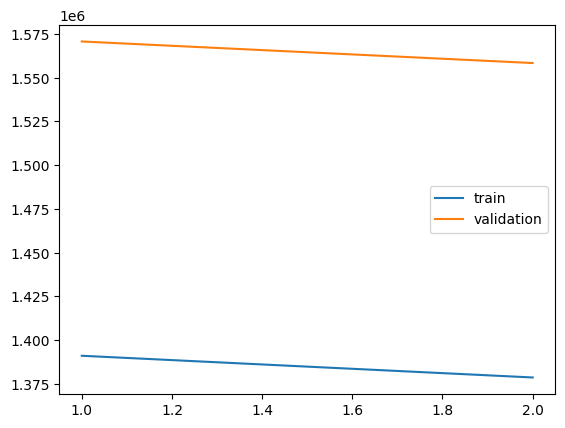

In [14]:
plt.plot(np.arange(1, len(losses) + 1), losses, label='train')
plt.plot(np.arange(1, len(val_losses) + 1), val_losses, label='validation')
plt.legend()
plt.show()

# EVALUATE

In [16]:
eval_df = eval_model_df(model, data_test)
test_rmse = mean_squared_error(eval_df['est_trues'], eval_df['est_preds'])
display(eval_df)
print('Test RMSE: %.3f' % test_rmse)

,est_trues,est_preds
0,430.0,11.831245
1,391.0,6.861576
2,44.0,3.988099
3,1610.0,14.592430
4,1476.0,14.592430
...,...,...
85,2200.0,14.592430
86,1093.0,14.592430
87,154.0,6.290938
88,1765.0,14.592430


Test RMSE: 1558395.488


In [43]:
for i in [2, 3, 4, 5, 6, 7, 8, 9]:
    print(90_000 / (i * (data_train[0][0].shape[2] + 1)))

348.83720930232556
232.5581395348837
174.41860465116278
139.53488372093022
116.27906976744185
99.66777408637874
87.20930232558139
77.51937984496124
